970 documents - 1.270MB (training set)
2 categories


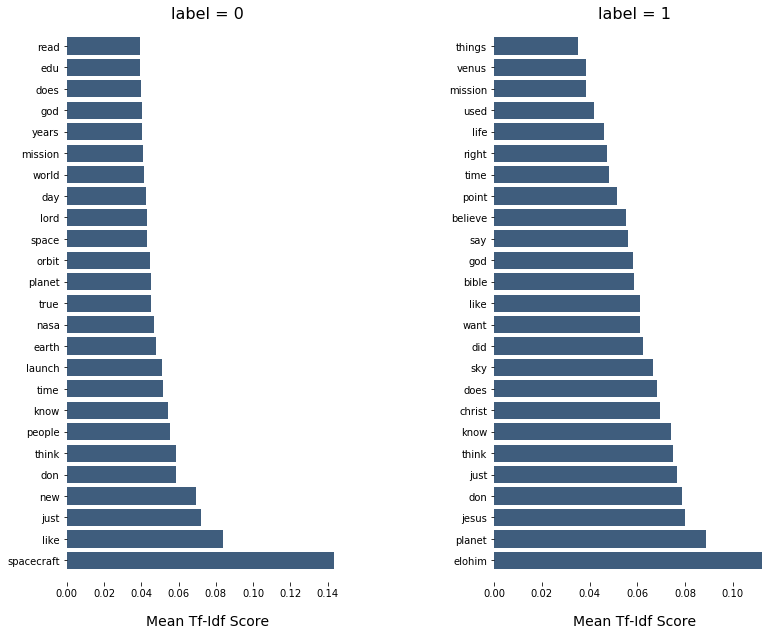

[ 2  3 10 14 38]


'\n\npyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)\npyplot.show()\n\n\n'

In [17]:
import logging
from time import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot

categories = [ 'sci.space','talk.religion.misc']
max_features_n = 20
remove = ('headers', 'footers', 'quotes')
data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6
target_names = data_train.target_names
data_train_size_mb = size_mb(data_train.data)
print("%d documents - %0.3fMB (training set)" % (
    len(data_train.data), data_train_size_mb))
print("%d categories" % len(target_names))
data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=remove)
y_train, y_test = data_train.target, data_test.target

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=.9,
                                 stop_words='english', max_features=50)
X_train = vectorizer.fit_transform(data_train.data)
X_test = vectorizer.fit_transform(data_test.data)
#print(X_train.shape)
#print(vectorizer.get_feature_names())
 
# get the first vector out (for the first document)
#first_vector_tfidfvectorizer=X_train[0]
 
# place tf-idf values in a pandas data frame
#df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=vectorizer.get_feature_names(), columns=["tfidf"])
#df.sort_values(by=["tfidf"],ascending=False)
features = vectorizer.get_feature_names()

y =y_train


def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

#top_tfidf_feats(X_train[1], features, top_n=50)

#top_feats_in_doc(X_train, features, 0, top_n=25)


def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

top_mean_feats(X_train, features, grp_ids=None, min_tfidf=0.1, top_n=25)


def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

dfs = top_feats_by_class(X_train, y, features, min_tfidf=0.1, top_n=25)


def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()
    
plot_tfidf_classfeats_h(dfs)


"""chi-sqaure"""

"""trying to print names of the features

selector = SelectKBest(score_func=chi2, k = 'all')
#New dataframe with the selected features for later use in the classifier. fit() method works too, if you want only the feature names and their corresponding scores
selector.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)
names = X_train.data[selector.get_support(indices=True)]
scores = selector.scores_[selector.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)


"""


# feature selection

fs = SelectKBest(score_func=chi2, k=5)
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

X_train_fs.shape

print(fs.get_support(indices=True))

"""garbag

mask = fs.get_support() #list of booleans
new_features = [] # The list of your K best features
feature_names = fs.get_feature_names()

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
dataframe = pd.DataFrame(fs)     
dataframe = pd.DataFrame(X_train_fs, columns=new_features)
dataframe.head(5)

"""

"""
# what are scores for the features
for i in range(len(fs.scores_)):
    print(i, fs.scores_[i] , fs.get_support())
# plot the scores
"""

"""

pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()


"""

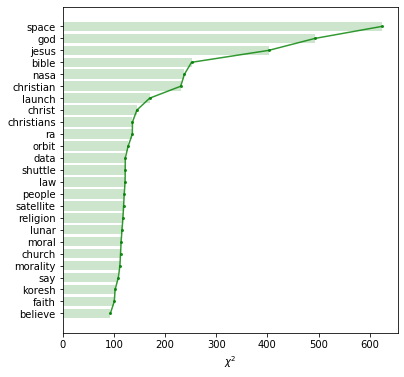

In [20]:
from sklearn.datasets import fetch_20newsgroups
 # newsgroups categories

    
"""chi sqaure top 25 """    
categories = ['talk.religion.misc',
              'sci.space'] 
              

posts = fetch_20newsgroups(subset='train', categories=categories,
                           shuffle=True, random_state=42,
                           remove=('headers','footers','quotes'))
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(lowercase=True,stop_words='english')
X = vectorizer.fit_transform(posts.data)
from sklearn.feature_selection import chi2
# compute chi2 for each feature
chi2score = chi2(X,posts.target)[0]
from pylab import barh,plot,yticks,show,grid,xlabel,figure
figure(figsize=(6,6))
wscores = zip(vectorizer.get_feature_names(),chi2score)
wchi2 = sorted(wscores,key=lambda x:x[1]) 
topchi2 = zip(*wchi2[-25:])
ff=list(topchi2)

x = range(len(ff[1]))
labels = ff[0]
barh(x,ff[1],align='center',alpha=.2,color='g')
plot(ff[1],x,'-o',markersize=2,alpha=.8,color='g')
yticks(x,labels)
xlabel('$\chi^2$')
show()


In [25]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2, SelectKBest
 # newsgroups categories

    
"""chi sqaure top 25 """    
categories = ['talk.religion.misc',
              'sci.space'] 
              

posts = fetch_20newsgroups(subset='train', categories=categories,
                           shuffle=True, random_state=42,
                           remove=('headers','footers','quotes'))

vectorizer = CountVectorizer(lowercase=True,stop_words='english')
X = vectorizer.fit_transform(posts.data)
y = posts.target

chi2_selector = SelectKBest(chi2, k=25)
chi2_selector.fit(X, y)

chi2_scores = pd.DataFrame(list(zip(vectorizer.get_feature_names(), chi2_selector.scores_, chi2_selector.pvalues_)), 
                                       columns=['ftr', 'score', 'pval'])
chi2_scores

kbest = np.asarray(vectorizer.get_feature_names())[chi2_selector.get_support()]
kbest

array(['believe', 'bible', 'christ', 'christian', 'christians', 'church',
       'data', 'faith', 'god', 'jesus', 'koresh', 'launch', 'law',
       'lunar', 'moral', 'morality', 'nasa', 'orbit', 'people', 'ra',
       'religion', 'satellite', 'say', 'shuttle', 'space'], dtype='<U79')

[0.7767441860465116, 0.7767441860465116, 0.7767441860465116, 0.7767441860465116, 0.7767441860465116, 0.7767441860465116, 0.7767441860465116, 0.7767441860465116, 0.7767441860465116, 0.7767441860465116, 0.7767441860465116, 0.7767441860465116, 0.7767441860465116, 0.7767441860465116, 0.7767441860465116, 0.7767441860465116, 0.7767441860465116, 0.7767441860465116, 0.7767441860465116]


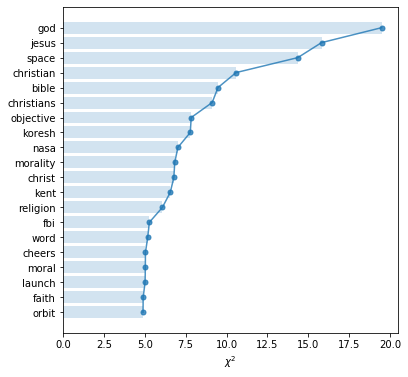

In [52]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

categories = ['talk.religion.misc','sci.space'] 
              
docs = fetch_20newsgroups(subset='train', categories=categories,
                           shuffle=True, random_state=42,
                           remove=('headers','footers','quotes'))

vectorizer = TfidfVectorizer(lowercase=True,stop_words='english')
X_train = vectorizer.fit_transform(docs.data)
y_train = docs.target

docs_test = fetch_20newsgroups(subset='test', categories=categories,
                           shuffle=True, random_state=42,
                           remove=('headers','footers','quotes'))

X_test = vectorizer.transform(docs_test.data)
y_test = docs_test.target

chi2score = chi2(X_train, y_train)[0]

plt.figure(figsize=(6,6))
wscores = zip(vectorizer.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = zip(*wchi2[-20:])
c = list(topchi2)
x = range(len(c[1]))
labels = c[0]
plt.barh(x,c[1], align='center', alpha=0.2)
plt.plot(c[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

from sklearn.feature_selection import SelectKBest, chi2
ch2_result = []
for n in np.arange(50,10000,50):
    ch2 = SelectKBest(chi2, k=25)
    x_train_chi2_selected = ch2.fit_transform(X_train, y_train)
    x_validation_chi2_selected = ch2.transform(X_test)
    clf = LogisticRegression()
    clf.fit(x_train_chi2_selected, y_train)
    score = clf.score(x_validation_chi2_selected, y_test)
    ch2_result.append(score)
print (ch2_result)


nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(np.arange(50,10000,50), ch2_result,label='tfidf dimesions reduced from 100,000 features',linestyle=':', color='orangered')

plt.title("tfidft vectorizer: features limited within tfidft vectorizer VS reduced dimensions with chi2")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

Text(0.5, 0, 'Mutual Info Score')

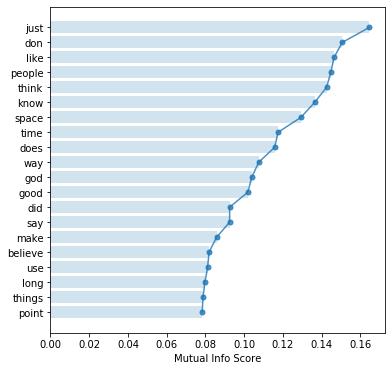

In [38]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif, SelectKBest
import matplotlib.pyplot as plt


  

categories = ['talk.religion.misc','sci.space'] 
              

docs = fetch_20newsgroups(subset='train', categories=categories,
                           shuffle=True, random_state=42,
                           remove=('headers','footers','quotes'))

vectorizer = TfidfVectorizer(lowercase=True,stop_words='english')
X_train = vectorizer.fit_transform(docs.data)
y_train = docs.target

chi2score = mutual_info_classif(X_train, y_train)
plt.figure(figsize=(6,6))
wscores = zip(vectorizer.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = zip(*wchi2[-20:])
c = list(topchi2)
x = range(len(c[1]))
labels = c[0]
plt.barh(x,c[1], align='center', alpha=0.2)
plt.plot(c[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('Mutual Info Score')


